주제: 이진분류기법(2)

목차

 1. 이진분류기법이란?
 2. Random Forest 와 Gradient Boosted model 소개 
 3. 데이터 확인 및 전처리
 4. Random Forest를 통한 분류(예측) 모델링
 5. Gradient Boosted model을 통한 분류(예측) 모델링
 6. 분류(예측) 모델링 결과 요약

# 1. 이진분류기법이란?

 -> 분류는 어떠한 변수에 영향을 받는 결과를 연속적이지 않은 값들로 나눌 때 사용합니다. 특히나, 이진 분류는 구분하고자 하는 결과값이 상호 배타적인 변수들 중 하나를 출력하는 분류 작업 유형입니다.
 
# 2. Random Forest와 Gradient Boosted model 소개

 * Random Forest 
 
  -> Random Forest는 다수의 결정 트리들을 학습하는 앙상블 방법입니다. Random Forest는 검출,분류, 그리고 회귀 등 다양한 문제에 활용되고 있습니다. Random Forest의 가장 큰 특징은 랜덤성에 의해 트리들이 서로 조금씩 다른 특성을 갖는다는 점입니다. 이 특성은 각 트리들의 예측(prediction)들이 비상관화되게하며, 결과적으로 일반화 성능을 향상시킵니다. 또한, 랜덤화는 forest가 노이즈가 포함된 데이터에 대해서도 강인하게 만들어 줍니다. 랜덤화는 각 트리들의 훈련 과정에서 진행되며, 랜덤 학습 데이터 추출 방법을 이용한 앙상블 학습법인 배깅과 랜덤 노드 최적화가 자주 사용됩니다. 이 두 가지 방법은 서로 동시에 사용되어 랜덤화 특성을 더욱 증진 시킬 수 있습니다. 
  
  
  * Gradient Boosted model
  
   -> Gradient Boosting은 회귀분석 또는 분류분석을 수행 할 수 있는 예측모형이며 예측 모형의 앙상블 방법론 중 부스팅 계열에 속하는 알고리즘입니다.이전 약한 분류 모델에서 발생된 잔차에 대해 다음의 약한 분류 모델을 적합시키는 것이 특징입니다. 

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

 - 데이터를 불러오기 앞서 데이터 분석시에 사용하는 라이브러리들을 불러오겠습니다.

# 3. 데이터 확인 및 전처리

 - 데이터 설명
 
  -> 브라질 최대의 자동차 및 주택소유자 보험회사 중 하나인 Porto Seguro에서 자동차 운전자가 다음년도에 자동차 보험 청구를 할 가능성에      대해 예측하는 모델을 구축하고자 수집된 데이터입니다. Porto Seguro에서는 정확한 예측을 통해 적정한 보험료를 책정하고 더 많은 운전     자들이 자동차 보험 혜택을 더 쉽게 받을 수 있게 하기위해 모델링을 추진하고자 합니다.

 - 데이터 확인

In [2]:
data = pd.read_csv("C:/Users/USER/Desktop/python 연습/data/porto-seguro-safe-driver-prediction/train.csv")
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


 -> 우선적으로 trainning set을 먼저 불러와서 데이터를 확인해보도록 하겠습니다. 데이터 안에는 위와 같은 변수들을 가지고 있습니다.

In [3]:
rows = data.shape[0]
columns = data.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


 -> trainning set는 총 595212개의 행과 59개의 열로 이루어져있습니다. 즉, 595212명의 보험 가입자와 그 사람에 관련된 59가지의 내역이 있다    고 보면됩니다. 

In [4]:
# checking for total null values(결측값 찾기)

data.isnull().any().any()

False

 -> 전체 train set의 결측값을 확인해보았을때, 우선 없는(False) 것으로 나타났습니다. 하지만, 모든 셀에 빈 값이 없다일 뿐이지 결측된 값을    대체하는 값(예로 들어, -1)을 가능성도 있기 때문에, 좀 더 자세히 살펴보도록 하겠습니다. 

In [5]:
train_copy = data 
train_copy = train_copy.replace(-1, np.NaN)

 -> 데이터에서 어떤 열이 -1을 포함하는지 알 수 있으므로 -1을 null로 교체하는 작업을 진행하였습니다.

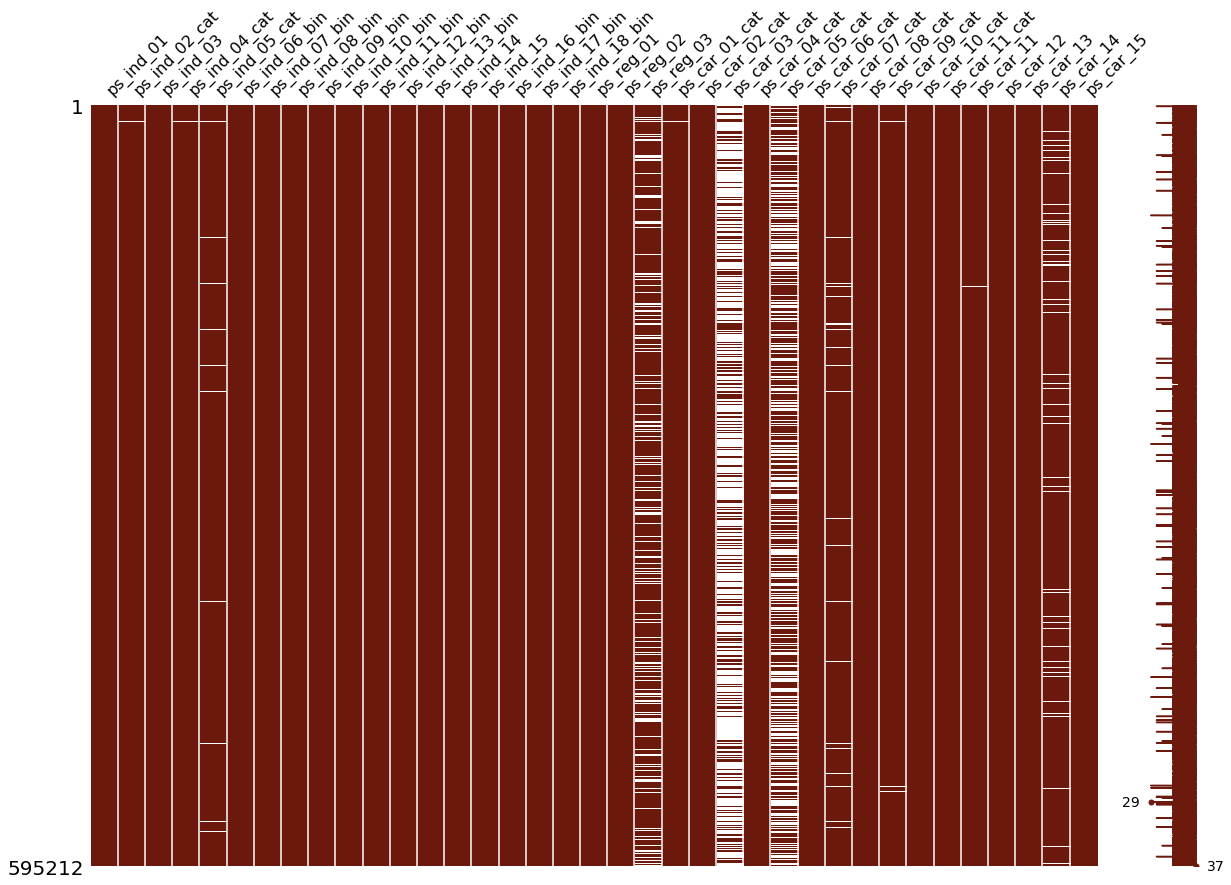

In [6]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df = train_copy.iloc[:,2:39], figsize = (20,14), color = (0.42, 0.1, 0.05))

 -> 데이터에서 -1 값을 null(누락)으로 바꾸고나서 결측 행렬도를 그려보았을때, 총 13개의 열에서 null이 있는 것으로 보여집니다(흰색띠 부     분) 그 중에서도 대부분이 null로 채워져있는 ps_reg_03, ps_car_03_cat 및 ps_car_05_cat열을 좀 더 자세히 살펴볼 필요는 있어 보입니다. 

 - 종속변수(반응변수) 확인 

In [7]:
data1 = [go.Bar(
x = data["target"].value_counts().index.values,
y = data["target"].value_counts().values,
text = 'Distribution of target variable'
)]

layout = go.Layout(
title = 'Target variable distribution'
)

fig = go.Figure(data = data1, layout = layout)

py.iplot(fig, filename = 'basic-bar')

  ->종속변수(반응변수) 확인 결과, 목표가 되는 변수(target = 1)가 상대적으로 많이 적어서 불균형하다는 것을 확인할 수 있습니다. 이를 해     결할 방법을 모색할 필요가 있어 보입니다. 

 - 데이터 유형 검사 

In [8]:
Counter(data.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

  -> 위에서 언급한 바와 같이, trainnig set을 구성하는 열은 총 59개이며, 정수(이산형)로 이루어진 데이터 49개, float(연속형)로 이루어진      데이터 10개의 유형으로 구성되어있습니다. 또 하나 주목할 점은 Porto Seguro가 실제로 "_bin","_cat" 및 "_reg"와 같은 약어가 혼재된        열이름을 제공하였는데, _bin은 이산형을 나타내고 _cat는 범주형 변수를 나타내며 나머지는 연속형 또는 순서형을 나타냅니다. float 값      은 연속형만 정수(이산형,범주형 및 순서형 변수) 두 가지로 더 단순화하여 모델링에 활용하고자 합니다. 

In [9]:
train_float = data.select_dtypes(include = ['float64'])
train_int = data.select_dtypes(include = ['int64'])

- 변수 간에 상관관계 확인

 -> float 변수들 간의 상관관계

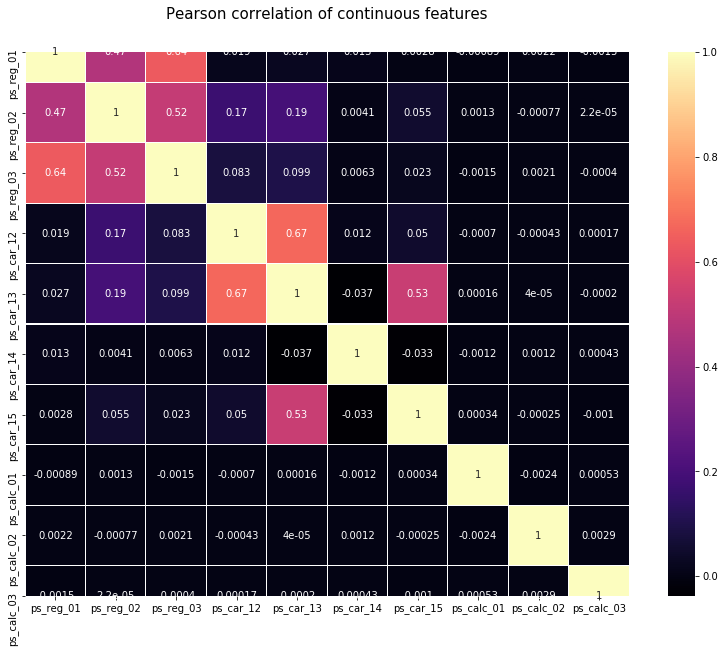

In [10]:
colormap = plt.cm.magma
plt.figure(figsize=(14,10))
plt.title('Pearson correlation of continuous features', y = 1.05, size = 15)
sns.heatmap(train_float.corr(), linewidths = 0.1, vmax = 1.0, square = True,
           cmap = colormap, linecolor = 'white', annot = True)

  ->상관관계 그림을 봤을 때, 전체적으로는 0에 가까움으로써 대부분이 서로 상관관계가 없음을 확인할 수 있습니다. 그리고 양의 상관관계를     나타내는 변수들의 쌍은 다음과 같았습니다. 

   (ps_reg_01, ps_reg_03)
   (ps_reg_02, ps_reg_03)
   (ps_car_12, ps_car_13)
   (ps_car_13, ps_car_15)


- integer 변수들 간의 상관관계

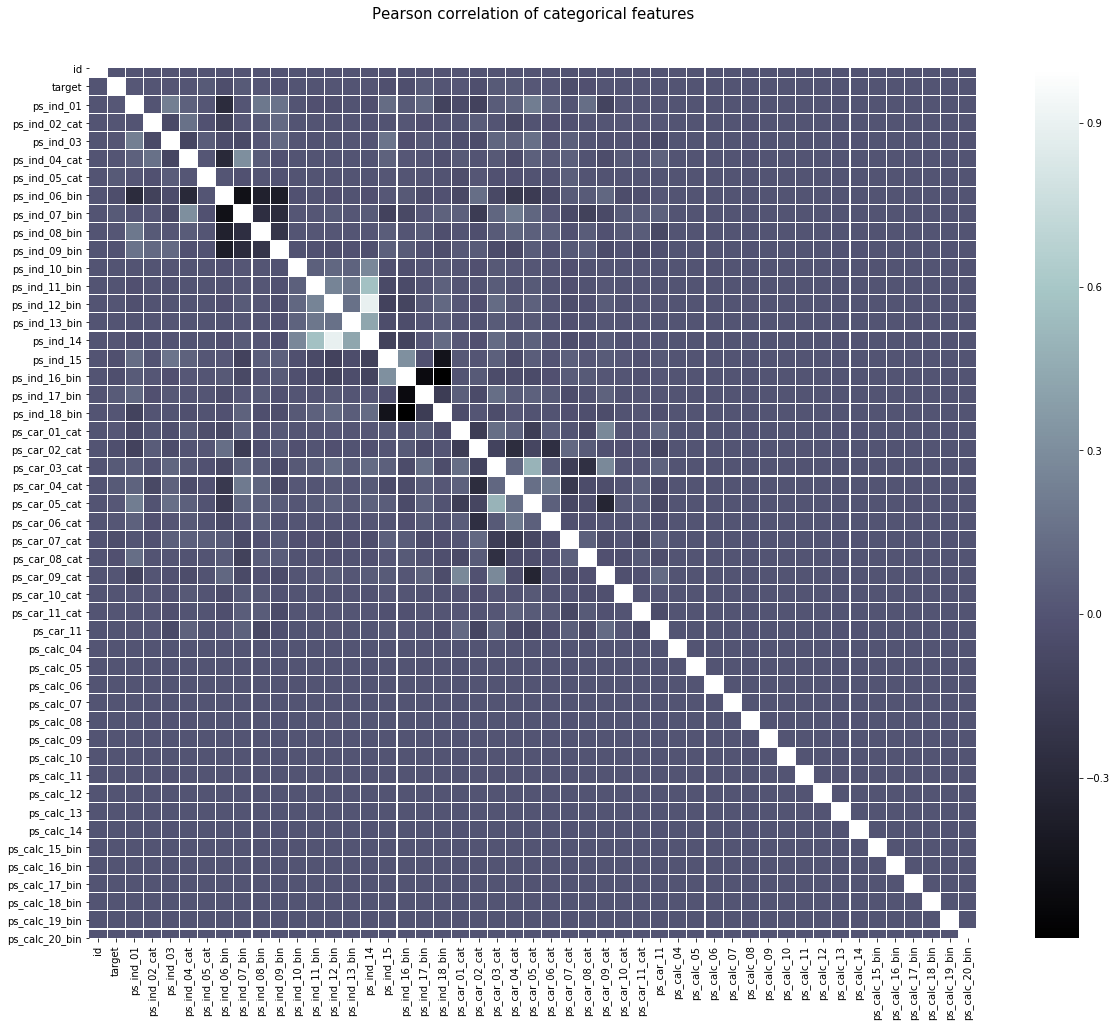

In [11]:
colormap = plt.cm.bone
plt.figure(figsize=(21,16))
plt.title('Pearson correlation of categorical features', y=1.05, size=15)
sns.heatmap(train_int.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)


  -> 마찬가지로, 상관관계 그림에서 0 값 셀을 꽤 많이 관찰할 수 있었습니다. 이 중에서도 이전의 결측값을 확인했을시, ps_car_03_cat와          ps_car_05_cat가 null값을 많이 포함하고 있는 것으로 확인되었는데, 양의 상관관계가 나타나는 것으로 확인되었습니다. 이 점은 모델링시      참고해볼만한 사항이라고 여겨집니다.

 - 상호정보 확인
  
  -> 상호 정보는 종속 변수(반응 변수)와 그것이 계산된 해당 변수 사이의 상호 정보를 검사하는 것입니다. 분류 문제의 경우, 2개의 임의의        변수와 임의 변수가 서로 독립되어 있는 경우의 0 값에서 일부 종속성을 나타내는 더 높은 값까지의 범위 사이의 종속성을 측정해야합니        다. 따라서, 대상의 정보가 변수 내에 얼마나 많이 포함될 수 있는지에 대한 아이디어를 제공하는데 도움이 될 것입니다. 

In [12]:
mf = mutual_info_classif(train_float.values, data.target.values, n_neighbors = 3,
                        random_state = 17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


 - 이진분류 변수 확인

In [13]:
bin_col = [col for col in data.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((data[col] == 0).sum())
    one_list.append((data[col] == 1).sum())

In [14]:
trace1 = go.Bar(
x = bin_col,
y = zero_list,
name = 'Zero count')

trace2 = go.Bar(
x = bin_col,
y = one_list,
name = 'One count')

data2 = [trace1, trace2]
layout = go.Layout(
barmode = 'stack',
title = 'Count of 1 and 0 binary variables')

fig = go.Figure(data = data2, layout = layout)
py.iplot(fig, filename = 'stacked-bar')

  -> 변수 안의 대부분의 값이 0인 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 4가지가 다른 등급들에 비해서 많은 정보를      포함하지 않기 때문에 전혀 유용하지 않을 수 있다는 생각을 가질 필요가 있어보입니다. 

# 4. Random Forests를 통한 분류(예측) 모델링

 - Random Forest와 변수의 중요성 확인
 
  -> Random Forest를 사용하기 위해 trainning set을 맞추고 모델링을 한 후 분류(예측)을 하는데 있어 어떤 변수가 유용한 변수였는지를 확인하고자 합니다. 

In [15]:
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators  = 150, max_depth = 8, min_samples_leaf = 4,
                           max_features = 0.2, n_jobs = -1, random_state = 0)
rf.fit(data.drop(['id', 'target'],axis = 1), data.target)
features = data.drop(['id', 'target'], axis = 1).columns.values
print("-----Training Done-----")

-----Training Done-----


- 그래프를 통한 변수의 중요성 확인

In [23]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
           sizemode = 'diameter',
           sizeref = 1, 
           size = 13,
           color = rf.feature_importances_,
           colorscale = 'Portland',
           showscale = True
    ),
    text = features
)
data3 = [trace]

layout = go.Layout(
        autosize = True,
        title = 'Random Forest Feature Importance',
        hovermode = 'closest',
        xaxis = dict(
            ticklen = 5,
            showgrid = False,
            zeroline = False,
            showline = False
        ),
        yaxis = dict(
            title = 'Feature Importance',
            showgrid = False,
            zeroline = False, 
            ticklen = 5, 
            gridwidth = 2
        ),
        showlegend = False
)

fig = go.Figure(data = data3, layout = layout)
py.iplot(fig, filename = 'scatter2010')

In [24]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                    reverse = False)))

trace2 = go.Bar(
    x = x,
    y = y,
    marker = dict(
        color = x,
        colorscale = 'Viridis',
        reversescale = True
    ), 
    name = 'Random Forest Feature importance',
    orientation = 'h',
)

layout = dict(
    title = 'Barplot of Feature importances',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True,
    ))

fig1 = go.Figure(data = [trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename = 'plots')

 -> 가장 중요도가 높게 나온 변수는 ps_car_13으로 약 0.1298이었습니다. 유일한 10%이상의 중요도를 차지하였고, 그 뒤로는 ps_ind_05_cat(약 0.0786), ps_reg_03(약 0.0717) 등이 뒤를 이었던 것을 확인할 수 있었습니다. 

* Decision Tree 시각화

  -> 분류(예측)의 기법 중 하나인 의사결정나무를 시각화를 통해 확인함으로써 모델링 과정이나 특성 좀 더 상세하게 확인할 수 있습니다. 

In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

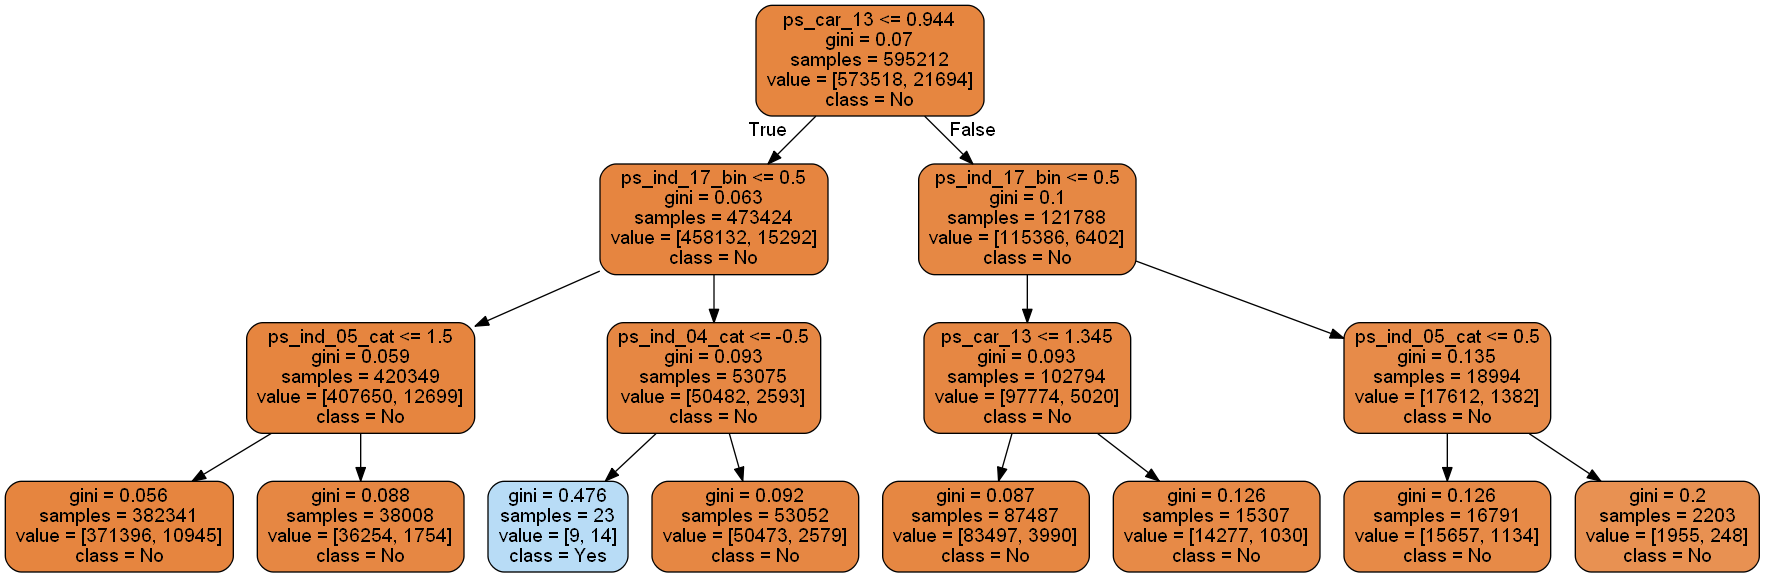

In [26]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(data.drop(['id', 'target'],axis=1), data.target)

dot_data = export_graphviz(decision_tree, out_file = None, feature_names = data.drop(['id','target'], axis = 1).columns.values, class_names = ['No', 'Yes'], rounded = True, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


# 5. Gradient Boosted model을 통한 분류(예측) 모델링

- Gradient Boosting과 변수의 중요성 확인

  -> Gradient Boosting을 사용하기 위해 trainning set을 맞추고 모델링을 한 후 분류(예측)을 하는데 있어 어떤 변수가 유용한 변수였는지를 확인하고자 합니다. 

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, min_samples_leaf = 4,
                               max_features = 0.2, random_state = 0)
gb.fit(data.drop(['id', 'target'], axis = 1), data.target)
features = data.drop(['id', 'target'], axis = 1).columns.values
print("----- Trainning Done-----")

----- Trainning Done-----


In [28]:
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = gb.feature_importances_,
        colorscale = 'Portland',
        showscale = True
    ),
    text = features
)
data4 = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boosting Machine Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = 'Feature Importance',
        showgrid = False, 
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data4, layout = layout)
py.iplot(fig, filename = 'scatter2010')

In [29]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

 -> Gradient Boosting에서 가장 중요하게 여겨진 변수는 ps_car_13으로 약 0.1348이었습니다. 그 다음으로는 ps_ind_05_cat(약 0.1095), ps_ind_17_bin(0.0975)이었습니다. 
 

* 두 분류(예측) 모델에서 선택한 가장 중요한 변수는 ps_car_13이었습니다. 이 변수에 대한 해석을 좀 더 명확하게 하기위해서는 좀 더 심층적으로 확인할 필요가 있어보입니다,

# 6. 분류(예측) 모델링 결과 요약

 - Random Forest 모델에서 가장 중요도가 높게 나온 변수는 ps_car_13으로 약 0.1298이었습니다. 유일한 10%이상의 중요도를 차지하였고, 그 뒤로는 ps_ind_05_cat(약 0.0786), ps_reg_03(약 0.0717) 등이 뒤를 이었던 것을 확인할 수 있었습니다.
 
 - Gradient Boosting 모델에서 가장 중요하게 여겨진 변수는 ps_car_13으로 약 0.1348이었습니다. 그 다음으로는 ps_ind_05_cat(약 0.1095), ps_ind_17_bin(0.0975)이었습니다.
 
 * 요약 : 두 분류(예측) 모델에서 선택한 가장 중요한 변수는 ps_car_13이었습니다. 이 변수에 대한 심층 분석을 통해 좀 더 확실한 인사이트를 얻을 필요가 있어 보입니다. 